## Imports

In [1]:
# To load .arff files
import arff

# Plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('retina')
plt.rc('figure', figsize=[10, 10])
plt.rc('font', size=18)

# For splitting the dataset into train and explain
import random
random.seed(42)

# Required imports
from src.XPLAIN_explainer import XPLAIN_explainer
from src.dataset import Dataset

/mnt/c/Users/andre/Desktop/tirocinio/src/../


## Importing a dataset

For this tutorial, we will be using the [Monks](https://archive.ics.uci.edu/ml/datasets/MONK%27s+Problems) dataset. This dataset has been already converted in the [`arff file format`](https://www.cs.waikato.ac.nz/ml/weka/arff.html) using the `liac-arff` library and is stored in the `datasets` directory of the repository's root.

### Why Monks

Monks is an artificial dataset, where the class: `y` is the result of this logical expression

$$y: (a == b) || (e == 1)$$

We chose this dataset because there is a clear interaction between the `a` and `b` attributes which the more advanced classifier will learn and use in their inference while others will not.

In [2]:
# TODO(Andrea): finish following https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html
with open("datasets/monks.arff") as f: # TODO(Andrea): Import from OpenML
    a = arff.load(f)

### Data format

`a['data']` is a matrix containing features and class of each row of the dataset

In [3]:
a['data'][:5]

[['1', '1', '1', '1', '3', '1', '1'],
 ['1', '1', '1', '1', '3', '2', '1'],
 ['1', '1', '1', '3', '2', '1', '1'],
 ['1', '1', '1', '3', '3', '2', '1'],
 ['1', '1', '2', '1', '2', '1', '1']]

`a['attributes']` is an ordered list of tuples describing the possible values of each column

In [4]:
a['attributes']

[('a', ['1', '2', '3']),
 ('b', ['1', '2', '3']),
 ('c', ['1', '2']),
 ('d', ['1', '2', '3']),
 ('e', ['1', '2', '3', '4']),
 ('f', ['1', '2']),
 ('y', ['0', '1'])]

### The `Dataset` class

With the data in this format, we can finally create the `Dataset` object.

In [5]:
dataset = Dataset(a['data'], a['attributes'])

### Splitting the dataset into `train` and `explain`

We then will split the dataset into `train_dataset` and `explain_dataset`. The train dataset will be used to create the locality for the L3 classifier. The explain dataset will be used to test the method's ability to generate explanations.

In [6]:
def train_explain_split(dataset):
    dataset_len = len(dataset)
    train_indices = list(range(dataset_len))

    explain_indices = list(
        random.sample(train_indices, round(dataset_len * 0.25)))
        
    for i in explain_indices:
        train_indices.remove(i)

    train_dataset = Dataset.from_indices(train_indices, dataset)
    explain_dataset = Dataset.from_indices(explain_indices, dataset)

    return train_dataset, explain_dataset

In [7]:
train_dataset, explain_dataset = train_explain_split(dataset)

## Training a classifier

Let's use Scikit-learn's Categorical Naive Bayes classifer. Naive Bayes classifiers consider all the features as independent, hence we should never see an explanation where the interaction between two features is important.

In [8]:
from sklearn.naive_bayes import CategoricalNB

clf = CategoricalNB()
clf = clf.fit(train_dataset.X_numpy(), train_dataset.Y_numpy())

## Evaluating the classifier's performance

In [9]:
from sklearn.metrics import accuracy_score

Y_pred = clf.predict(explain_dataset.X_numpy())
accuracy_score(explain_dataset.Y_numpy(), Y_pred)

0.7338129496402878

## Explaining predictions

To explain a prediction we need to instantiate a `XPLAIN_explainer` object.

In [10]:
explainer = XPLAIN_explainer(clf, train_dataset)

Then, we pick an instance which we want to explain with respect to a class. Let's pick instance `4` and class: `'1'`

In [11]:
explain_dataset.get_decoded(4)

a    1
b    3
c    1
d    2
e    1
f    1
y    1
Name: 228, dtype: object

This instance has class `1` because `e == 1`, while `a != b`. (Recall the rule $y: (a==b) || (e==1)$)

To explain an instance, we need to pass its *encoded* form to `explain_instance`. The encoded form can be obtained from a dataset object using the attribute syntax: `dataset[instance_index]`.

In [12]:
instance = explain_dataset[4]
class_ = '1'

In [13]:
explanation = explainer.explain_instance(instance, class_)
explanation

compute_lace_step k=20
compute_lace_step k=40
compute_lace_step k=60
compute_lace_step k=80
compute_lace_step k=100
compute_lace_step k=120
compute_lace_step k=140
compute_lace_step k=160
compute_lace_step k=180
compute_lace_step k=200
explain_instance errors: 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02, 5.870E-02


{'XPLAIN_explainer_o': <src.XPLAIN_explainer.XPLAIN_explainer at 0x7fb96193d9b0>,
 'diff_single': [-0.0043078866498516,
  -0.000924579280960014,
  -0.0006868395944223948,
  -0.005513141681877443,
  0.5664958295415631,
  -0.0008304050766636539],
 'map_difference': {'5': 0.5681447767652239},
 'k': 200,
 'error': 0.058702652938482314,
 'instance': a    1
 b    3
 c    1
 d    2
 e    1
 f    1
 y    1
 dtype: object,
 'target_class': '1',
 'errors': [0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314,
  0.058702652938482314],
 'instance_class_index': 1,
 'prob': 0.985011402022745}

## Visualizing explanations

In [14]:
def plot(e):

    fig, pred_ax = plt.subplots(1, 1)
    
    attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
    values = [f"{k}={v}" for k,v in (e['instance'].items())]
    nls = ", ".join(values)
    
    pred_ax.set_title(
f"""Importance
P[y={e['target_class']} | x=({nls})]={e['prob']:.3f}""", pad=12
    )
    pred_ax.set_ylabel("Attribute or rule", labelpad=2)
    pred_ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x A_i]$",labelpad=12)
    
    pred_ax.grid(True)
    
    pred_ax.barh(
        attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
        width=e['diff_single'] + list(e['map_difference'].values())
    )

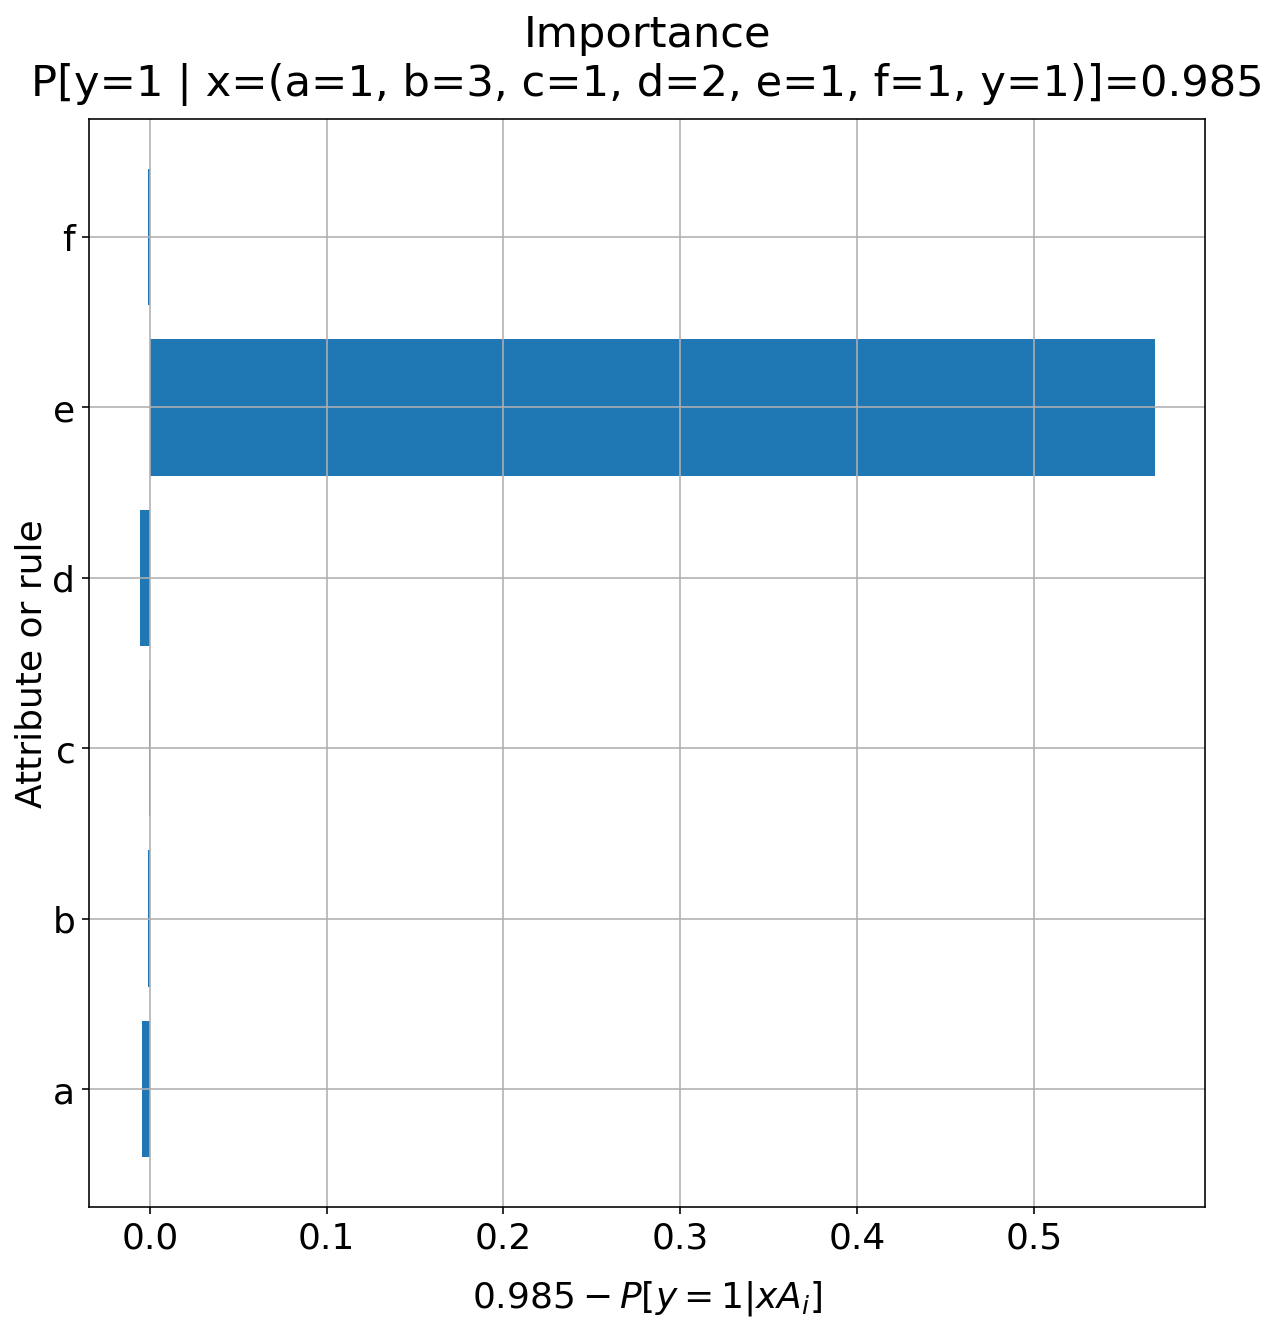

In [15]:
plot(explanation)

## More instances

For this instance `a!=b` and `e!=1` thus `y=0`. Notice how the rule `a==b` does not appear and therefore the classifier has decided that `y=0` only because of the `e` feature.

a    1
b    2
c    2
d    3
e    3
f    2
y    0
Name: 25, dtype: object
compute_lace_step k=20
compute_lace_step k=40
compute_lace_step k=60
compute_lace_step k=80
compute_lace_step k=100
compute_lace_step k=120
compute_lace_step k=140
compute_lace_step k=160
compute_lace_step k=180
compute_lace_step k=200
explain_instance errors: 1.949E-01, 1.949E-01, 1.949E-01, 1.949E-01, 1.949E-01, 1.949E-01, 1.949E-01, 1.949E-01, 3.708E-02, 3.708E-02


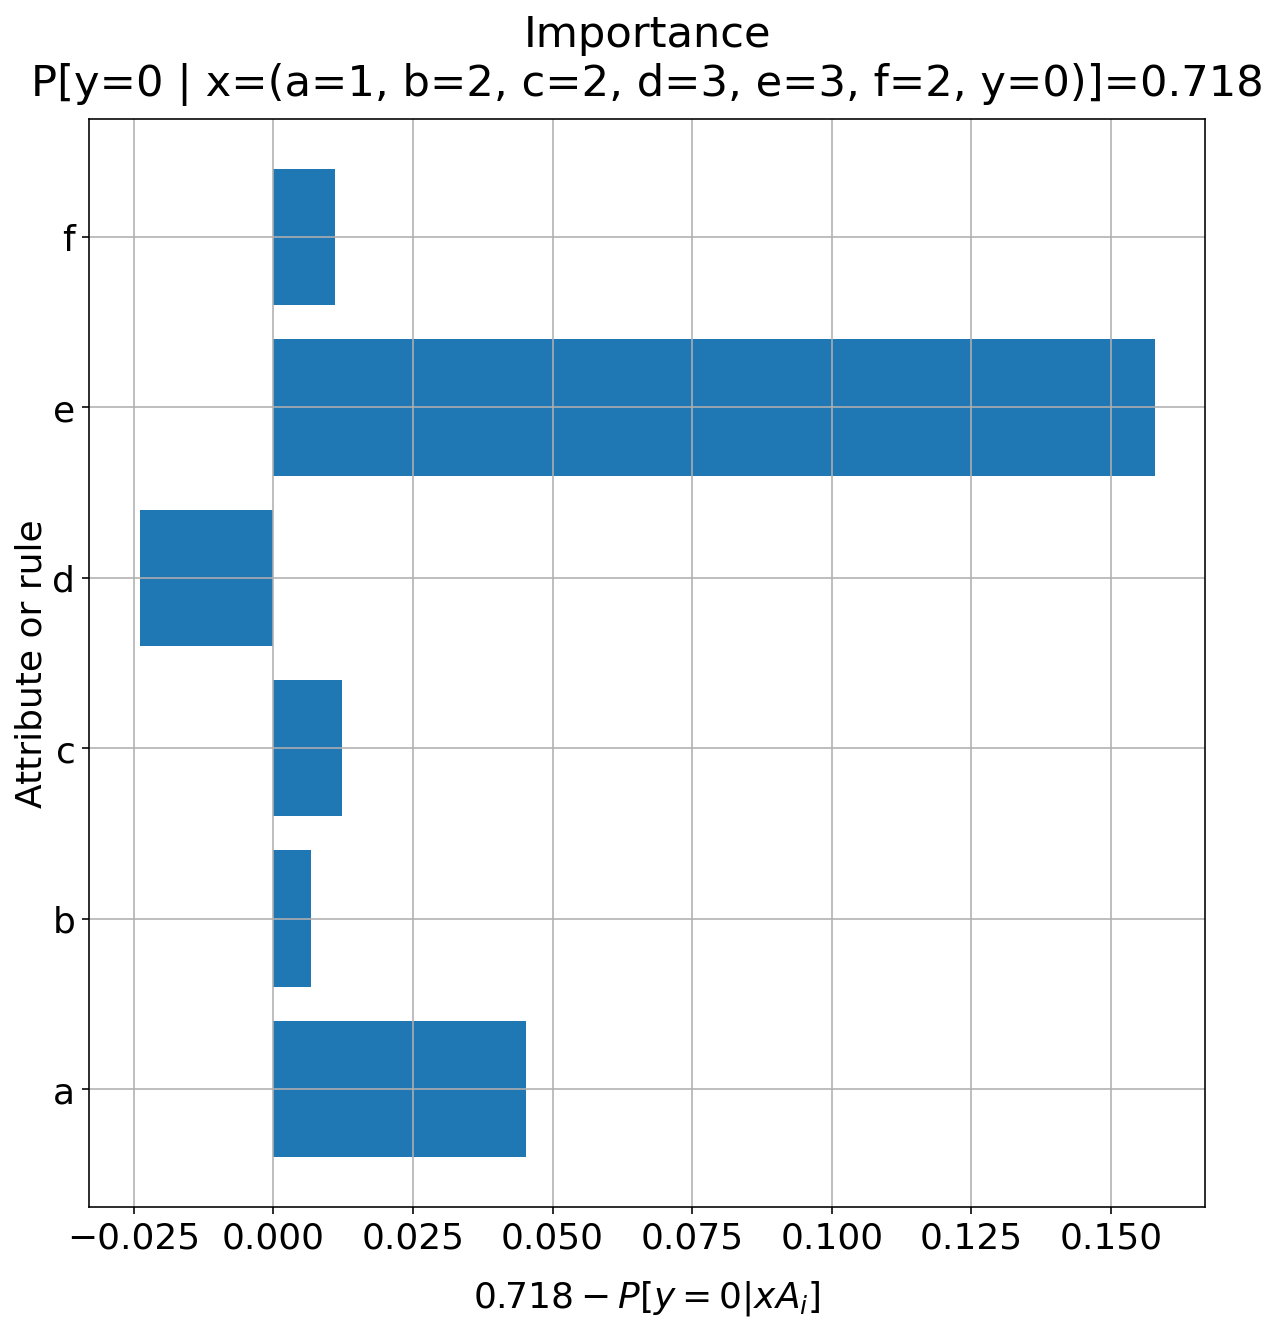

In [16]:
instance = explain_dataset[1]
class_ = '0'
print(explain_dataset.get_decoded(1))
explanation = explainer.explain_instance(instance, class_)
plot(explanation)

We can confirm our hypothesis by analyzing the probabilities associated to each feature value of the classifier

In [17]:
import numpy as np
np.exp(clf.feature_log_prob_[4]) # feature 'e'

array([[0.0045045 , 0.35135135, 0.33783784, 0.30630631],
       [0.4729064 , 0.15270936, 0.18226601, 0.19211823]])

$$P[y=0|e=1]$$

In [18]:
np.exp(clf.feature_log_prob_[4][0][0])

0.004504504504504505

$$P[y=1|e=1]$$

In [19]:
np.exp(clf.feature_log_prob_[4][1][0])

0.47290640394088673

## More classifiers

Let's explain the previous instance by using a more powerful model: a neural network.

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

# TODO(Andrea): trainare il nn in modo che abbia onehot output? 
#               Magari cosi funziona con un hidden layer piu piccolo.
clf = make_pipeline(
    OneHotEncoder(),
    MLPClassifier(
        random_state=42,
        max_iter=1000,
        hidden_layer_sizes=(3,)
    ))

clf = clf.fit(train_dataset.X_numpy(), train_dataset.Y_numpy())

/home/andrea/venv-environments/lace/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [21]:
clf[1].coefs_

[array([[ 0.15606782,  0.31594794, -0.20216967],
        [ 0.76906831, -1.21387387, -0.76624861],
        [-1.54339109,  1.3864378 ,  1.285245  ],
        [ 0.73408903,  0.74089903,  1.28796781],
        [ 0.77088769, -1.15517014,  0.36367896],
        [-1.51052257, -0.51177994, -1.76409574],
        [ 0.02409664, -0.01465231, -0.03547605],
        [ 0.02884053, -0.01610507, -0.04434248],
        [ 0.37891785,  0.23759381, -0.4304104 ],
        [-0.05322115,  0.16389947, -0.44483821],
        [ 0.33680352,  0.2228243 , -0.45113596],
        [ 1.78195117,  1.54038211, -0.17750128],
        [-0.65765175, -0.46324469,  0.26561231],
        [-0.66300276, -0.40979227,  0.26784263],
        [-0.59121972, -0.40331381,  0.22333817],
        [ 0.37084038, -0.06743652,  0.25822083],
        [ 0.36821121, -0.06119591,  0.27032453]]),
 array([[ 1.46677156],
        [ 2.92659751],
        [-2.47179664]])]

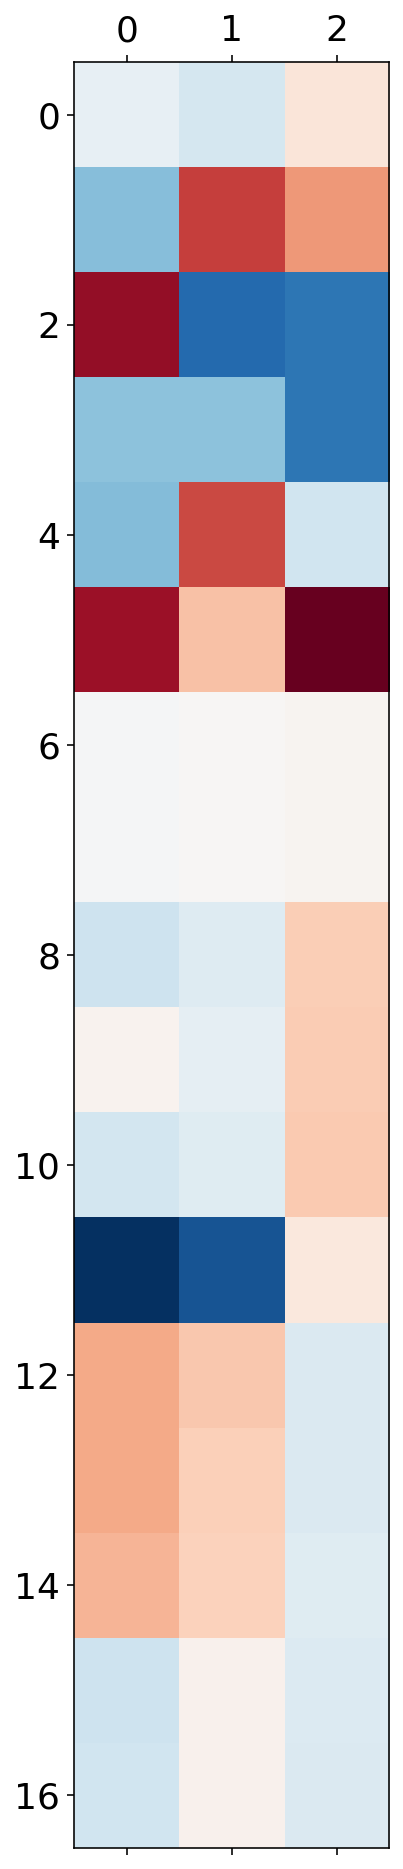

In [22]:
plt.matshow(clf[1].coefs_[0], cmap='RdBu')

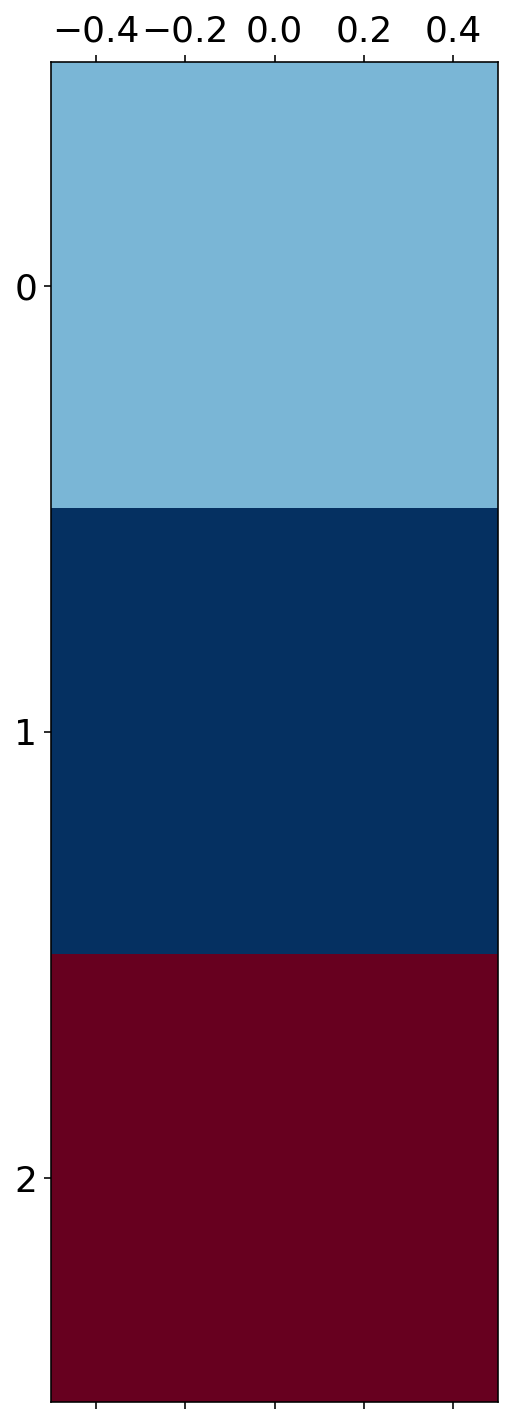

In [23]:
plt.matshow(clf[1].coefs_[1], cmap='RdBu')

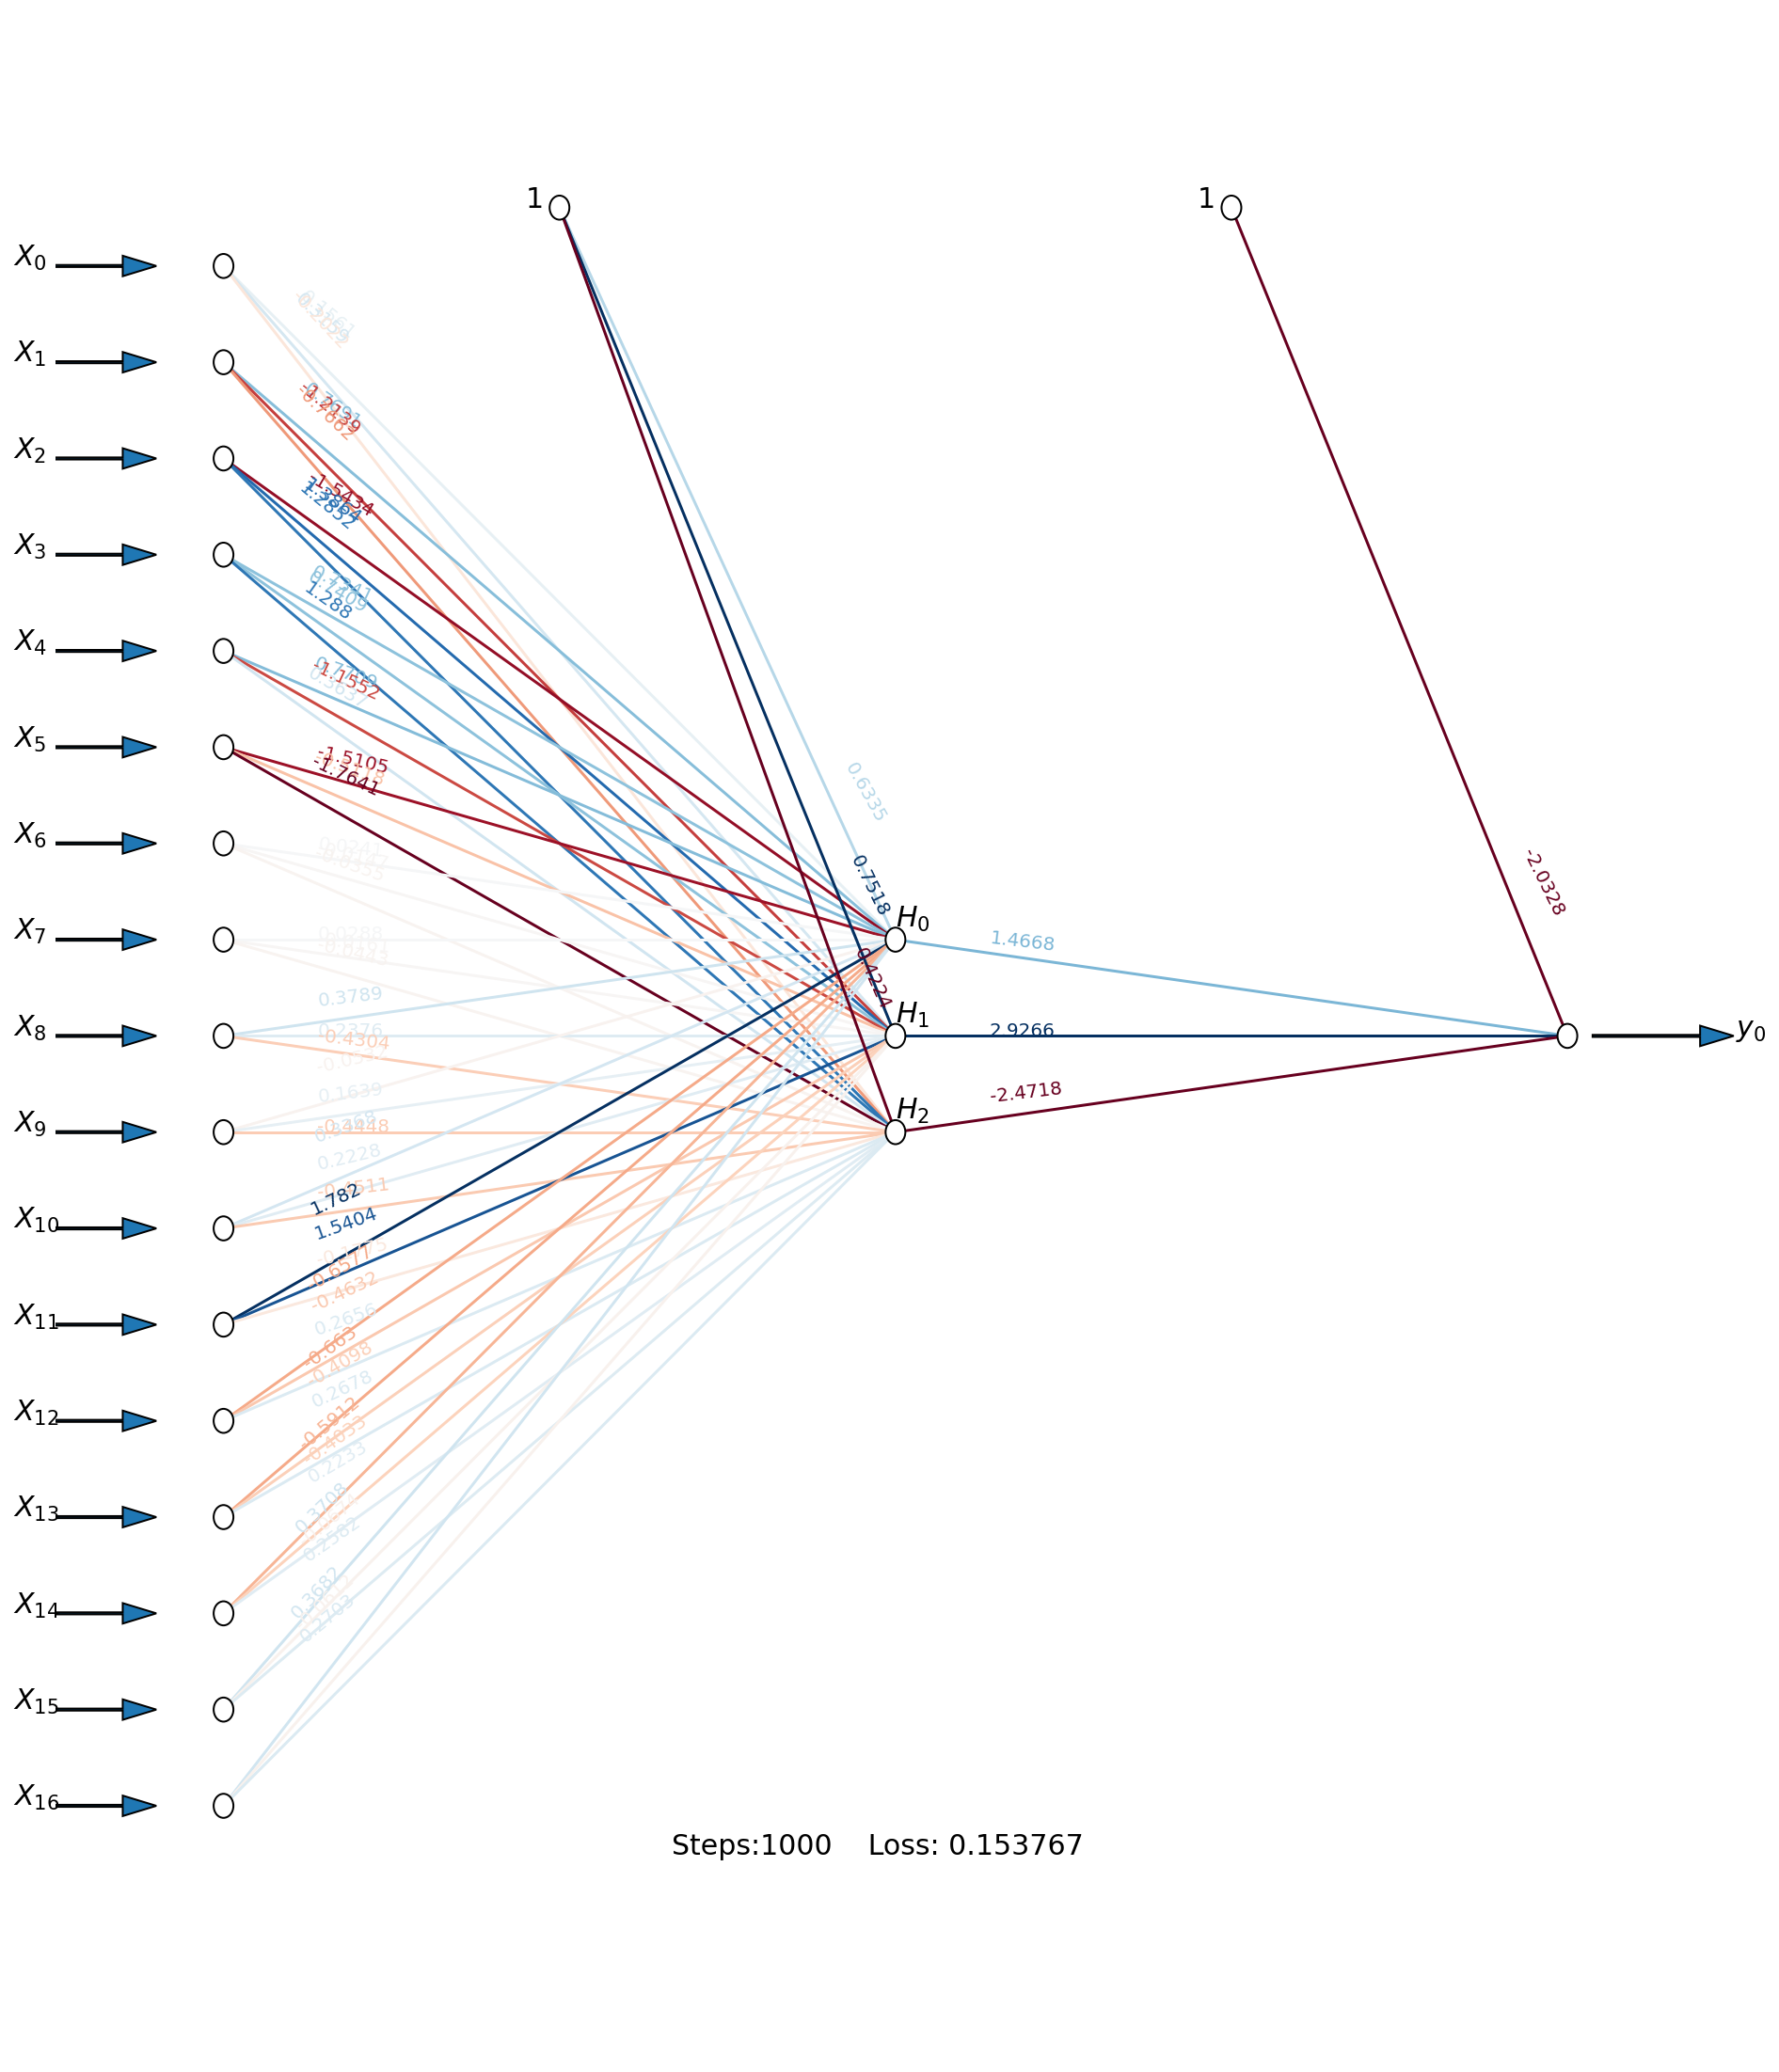

In [24]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes, coefs_, intercepts_, n_iter_, loss_):
    import matplotlib.cm as cm
    from matplotlib.colors import Normalize
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    
    # Input-Arrows
    layer_top_0 = v_spacing*(layer_sizes[0] - 1)/2. + (top + bottom)/2.
    for m in range(layer_sizes[0]):
        plt.arrow(left-0.18, layer_top_0 - m*v_spacing, 0.12, 0,  lw =1, head_width=0.01, head_length=0.02)
    
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/8.,
                                color='w', ec='k', zorder=4)
            if n == 0:
                plt.text(left-0.125, layer_top - m*v_spacing, r'$X_{'+str(m)+'}$', fontsize=15)
            elif (n_layers == 3) & (n == 1):
                plt.text(n*h_spacing + left+0.00, layer_top - m*v_spacing+ (v_spacing/8.+0.01*v_spacing), r'$H_{'+str(m)+'}$', fontsize=15)
            elif n == n_layers -1:
                plt.text(n*h_spacing + left+0.10, layer_top - m*v_spacing, r'$y_{'+str(m)+'}$', fontsize=15)
            ax.add_artist(circle)
    # Bias-Nodes
    for n, layer_size in enumerate(layer_sizes):
        if n < n_layers -1:
            x_bias = (n+0.5)*h_spacing + left
            y_bias = top + 0.005
            circle = plt.Circle((x_bias, y_bias), v_spacing/8., color='w', ec='k', zorder=4)
            plt.text(x_bias-(v_spacing/8.+0.10*v_spacing+0.01), y_bias, r'$1$', fontsize=15)
            ax.add_artist(circle)   
    # Edges
    # Edges between nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                norm = Normalize(vmin=np.min(coefs_[n]), vmax=np.max(coefs_[n]))
                cmap = cm.RdBu
                x = coefs_[n][m, o]
                scm = cm.ScalarMappable(norm=norm, cmap=cmap)
                
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c=scm.to_rgba(x))
                ax.add_artist(line)
                xm = (n*h_spacing + left)
                xo = ((n + 1)*h_spacing + left)
                ym = (layer_top_a - m*v_spacing)
                yo = (layer_top_b - o*v_spacing)
                rot_mo_rad = np.arctan((yo-ym)/(xo-xm))
                rot_mo_deg = rot_mo_rad*180./np.pi
                xm1 = xm + (v_spacing/8.+0.05)*np.cos(rot_mo_rad)
                if n == 0:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.12)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.05)*np.sin(rot_mo_rad)
                else:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.12)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.04)*np.sin(rot_mo_rad)
                plt.text( xm1, ym1,\
                         str(round(coefs_[n][m, o],4)),\
                         rotation = rot_mo_deg, \
                         fontsize = 10,c=scm.to_rgba(x))
    # Edges between bias and nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        if n < n_layers-1:
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        x_bias = (n+0.5)*h_spacing + left
        y_bias = top + 0.005 
        for o in range(layer_size_b):
            norm = Normalize(vmin=np.min(intercepts_[n]), vmax=np.max(intercepts_[n]))
            cmap = cm.RdBu
            x = intercepts_[n][o]
            scm = cm.ScalarMappable(norm=norm, cmap=cmap)
            
            
            line = plt.Line2D([x_bias, (n + 1)*h_spacing + left],
                          [y_bias, layer_top_b - o*v_spacing], c=scm.to_rgba(x))
            ax.add_artist(line)
            xo = ((n + 1)*h_spacing + left)
            yo = (layer_top_b - o*v_spacing)
            rot_bo_rad = np.arctan((yo-y_bias)/(xo-x_bias))
            rot_bo_deg = rot_bo_rad*180./np.pi
            xo2 = xo - (v_spacing/8.+0.01)*np.cos(rot_bo_rad)
            yo2 = yo - (v_spacing/8.+0.01)*np.sin(rot_bo_rad)
            xo1 = xo2 -0.05 *np.cos(rot_bo_rad)
            yo1 = yo2 -0.05 *np.sin(rot_bo_rad)
            plt.text( xo1, yo1,\
                 str(round(intercepts_[n][o],4)),\
                 rotation = rot_bo_deg, \
                 fontsize = 10,c=scm.to_rgba(x))    
                
    # Output-Arrows
    layer_top_0 = v_spacing*(layer_sizes[-1] - 1)/2. + (top + bottom)/2.
    for m in range(layer_sizes[-1]):
        plt.arrow(right+0.015, layer_top_0 - m*v_spacing, 0.16*h_spacing, 0,  lw =1, head_width=0.01, head_length=0.02)
    # Record the n_iter_ and loss
    plt.text(left + (right-left)/3., bottom - 0.005*v_spacing, \
             'Steps:'+str(n_iter_)+'    Loss: ' + str(round(loss_, 6)), fontsize = 15)
    
layer_sizes = [17] + list((3,)) + [1]
fig = plt.figure(figsize=(16, 20))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, layer_sizes, clf[1].coefs_, clf[1].intercepts_, clf[1].n_iter_, clf[1].loss_)

In [25]:
from sklearn.metrics import accuracy_score

Y_pred = clf.predict(explain_dataset.X_numpy())
accuracy_score(explain_dataset.Y_numpy(), Y_pred)

1.0

a    1
b    2
c    2
d    3
e    3
f    2
y    0
Name: 25, dtype: object
compute_lace_step k=20
compute_lace_step k=40
compute_lace_step k=60
compute_lace_step k=80
compute_lace_step k=100
compute_lace_step k=120
compute_lace_step k=140
compute_lace_step k=160
compute_lace_step k=180
compute_lace_step k=200
explain_instance errors: 1.102E-01, 1.102E-01, 1.102E-01, 1.102E-01, 3.503E-02, 3.503E-02, 3.503E-02, 3.503E-02, 3.503E-02, 3.503E-02


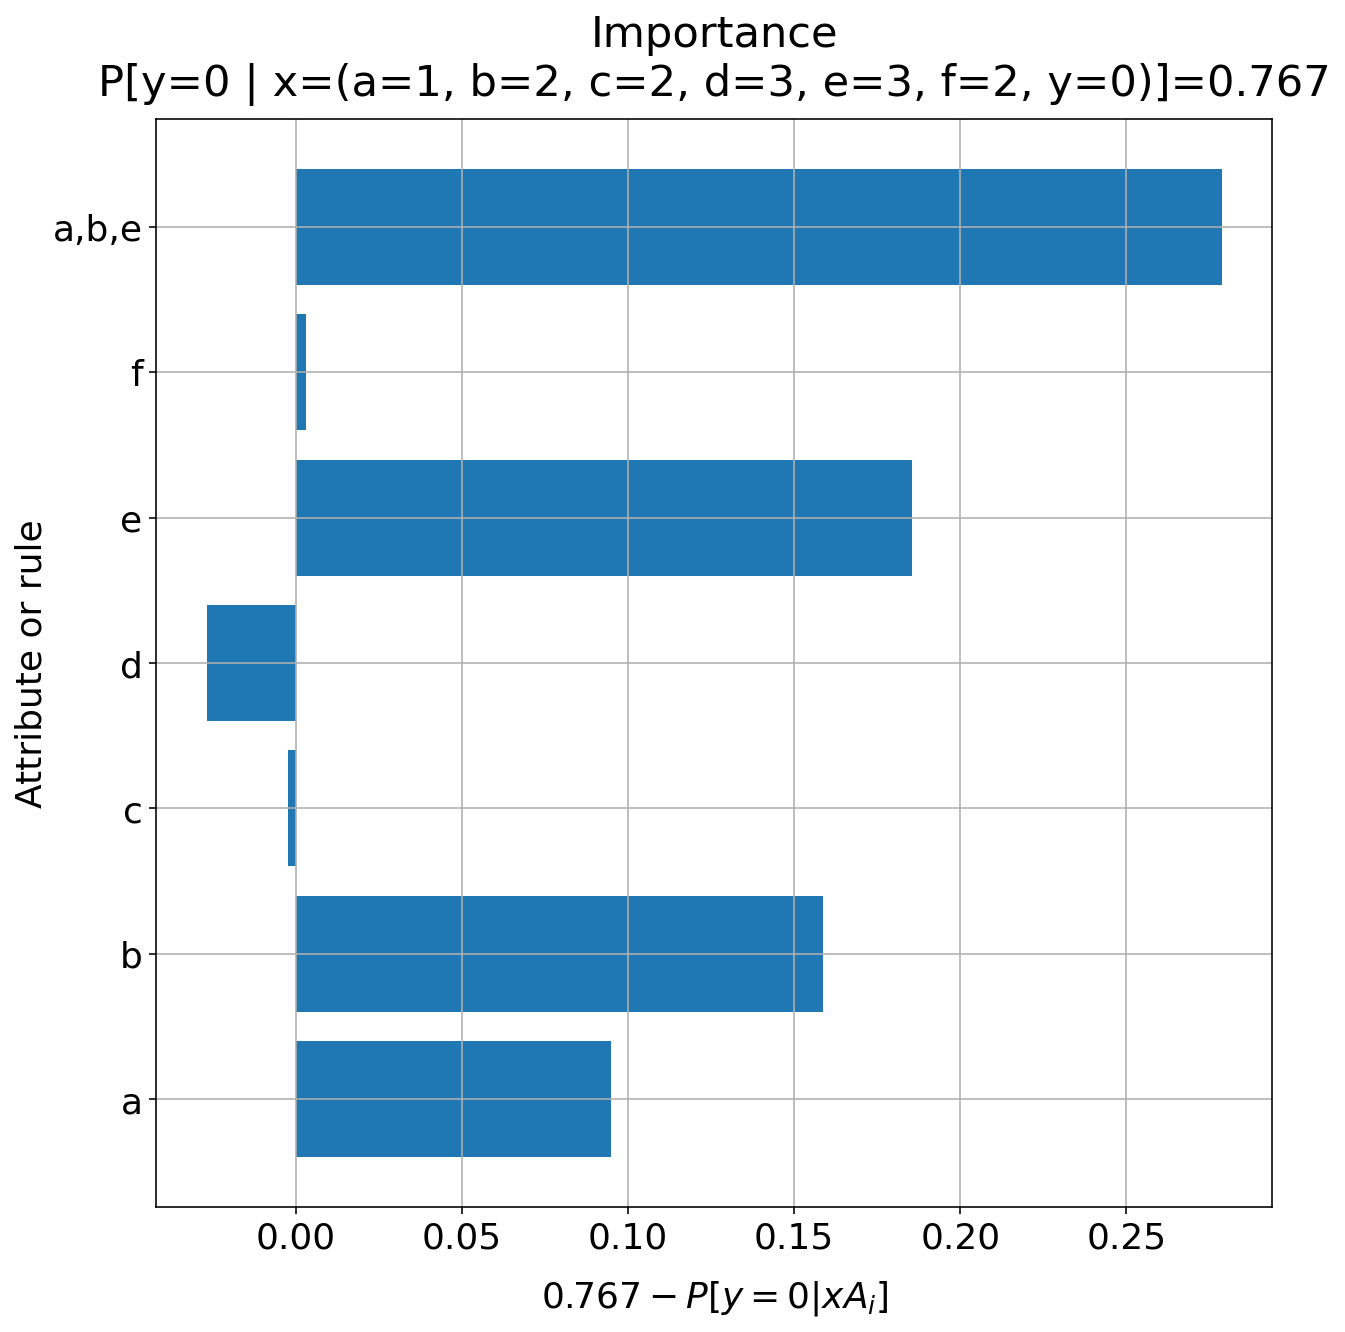

In [26]:
explainer = XPLAIN_explainer(clf, train_dataset)

instance = explain_dataset[1]
class_ = '0'
print(explain_dataset.get_decoded(1))
explanation = explainer.explain_instance(instance, class_)
plot(explanation)